#### Load libraries

In [1]:
print('load libraries')
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import cftime

load libraries


In [ ]:
fin_all_loop = """
███████╗██╗███╗   ██╗    ███████╗██╗███╗   ██╗    ███████╗██╗███╗   ██╗
██╔════╝██║████╗  ██║    ██╔════╝██║████╗  ██║    ██╔════╝██║████╗  ██║
█████╗  ██║██╔██╗ ██║    █████╗  ██║██╔██╗ ██║    █████╗  ██║██╔██╗ ██║
██╔══╝  ██║██║╚██╗██║    ██╔══╝  ██║██║╚██╗██║    ██╔══╝  ██║██║╚██╗██║
██║     ██║██║ ╚████║    ██║     ██║██║ ╚████║    ██║     ██║██║ ╚████║
╚═╝     ╚═╝╚═╝  ╚═══╝    ╚═╝     ╚═╝╚═╝  ╚═══╝    ╚═╝     ╚═╝╚═╝  ╚═══╝
"""

fin_for_loop = """
███████╗██╗███╗   ██╗
██╔════╝██║████╗  ██║
█████╗  ██║██╔██╗ ██║
██╔══╝  ██║██║╚██╗██║
██║     ██║██║ ╚████║
╚═╝     ╚═╝╚═╝  ╚═══╝
"""

In [3]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

#### Load and process data

In [4]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})

In [12]:
snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")#chunks={'time':1})

In [13]:
#Merge snapshots with time-averages
snap = snap.rename({
    **{'time': 'time_bounds'},
    **{v: f"{v}_bounds" for v in snap.data_vars}
    })

In [14]:
mt_path = "/pub/mariant3/WarmWaterMasses/notebooks/02_mhw_metrics/data_ocetrac-labels/"
blobs = xr.open_dataset(f"{mt_path}/01860503-01901020_ocetrac-labels-region.nc")
labels = blobs.blobs.rename('event_mask')
df = pd.read_pickle(f"{mt_path}/01860503-01901020_mhw-metrics-region.pkl")
df;

#### Beginning of analysis

In [15]:
ids = np.unique(labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([  3.,   6.,  22.,  25.,  26.,  32.,  34.,  35.,  36.,  37.,  40.,
        41.,  42.,  45.,  48.,  49.,  50.,  51.,  55.,  56.,  58.,  69.,
        71.,  74.,  75.,  78.,  79.,  80.,  84.,  86.,  87.,  88.,  89.,
        90.,  91.,  94.,  98.,  99., 101., 103., 112., 113., 116., 118.,
       119., 120., 122., 127., 128., 130., 132., 133., 143., 145., 146.,
       148., 153., 156., 158., 159., 171., 184., 186., 189., 190., 194.,
       201., 202., 208., 212., 220., 221., 223., 224., 226., 227., 228.,
       231., 237., 242., 244., 246., 247., 249., 252., 256.])

In [16]:
one_day_ids = df[df['duration'] == 1]['id'].tolist()
# Remove ids from the original labels array
ids = np.array([id for id in ids if id not in one_day_ids])
ids

array([  3.,   6.,  25.,  26.,  32.,  37.,  40.,  41.,  42.,  48.,  49.,
        50.,  51.,  58.,  69.,  71.,  74.,  78.,  79.,  80.,  84.,  86.,
        87.,  89.,  90.,  91.,  94.,  98.,  99., 101., 103., 112., 113.,
       116., 120., 122., 130., 132., 133., 143., 145., 148., 153., 156.,
       159., 171., 184., 186., 189., 201., 212., 220., 221., 223., 224.,
       226., 228., 231., 237., 242., 244., 246., 247., 256.])

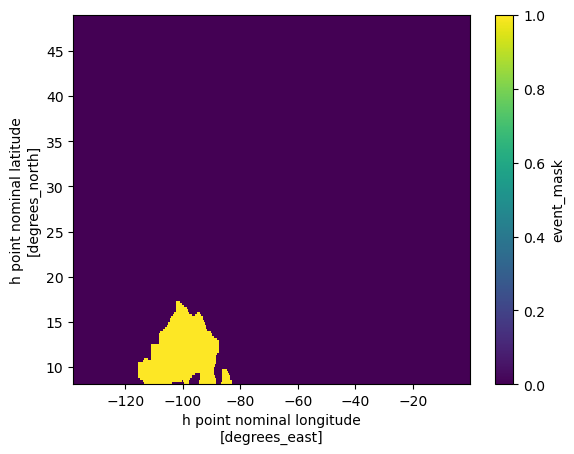

In [41]:
(labels == 201).any("time").plot()

In [64]:
event = (labels == mhw).any("time")
ds_event = xr.merge([ds, event], join="inner")
ds_event = xr.merge([ds_event.sel(time=ds_event.time[1:]), snap])
ds_event = xr.merge([static, ds_event], join='inner')

def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})

ds_event = add_estimated_layer_interfaces(ds_event)

print('----------------- Adding core coordinates of static to ds_event -----------------')

ds_event = ds_event.assign_coords({
    "areacello": xr.DataArray(ds_event["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(ds_event["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(ds_event["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds_event["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds_event["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds_event["geolat_c"].values, dims=('yq', 'xq',)),
})
coords = {
'X': {'center': 'xh', 'outer': 'xq'},
'Y': {'center': 'yh', 'outer': 'yq'},
'Z': {'center': 'zl', 'outer': 'zi'}
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds_event['tos'] = ds_event['thetao'].isel(zl=0)
grid = xgcm.Grid(ds_event.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)
wm = xwmt.WaterMass(grid)

ds_event

----------------- Adding core coordinates of static to ds_event -----------------


<xarray.Dataset>
Dimensions:                         (xh: 269, yh: 130, yq: 131, xq: 270,
                                     time: 1459, zl: 75, time_bounds: 1460,
                                     zi: 76)
Coordinates: (12/16)
  * xh                              (xh) float64 -137.9 -137.7 ... -70.16 -69.91
  * yh                              (yh) float64 10.2 10.44 ... 38.87 39.07
    geolat                          (yh, xh) float32 10.2 10.2 ... 39.07 39.07
    geolat_c                        (yq, xq) float32 10.32 10.32 ... 39.36 39.36
    geolon                          (yh, xh) float32 -137.4 -137.1 ... -70.38
    geolon_c                        (yq, xq) float32 -137.2 -137.0 ... -70.0
    ...                              ...
  * time_bounds                     (time_bounds) object 0186-01-02 00:00:00 ...
  * zi                              (zi) float64 0.0 2.0 4.0 ... 4.351e+03 6e+03
    lon                             (yh, xh) float32 -137.4 -137.1 ... -70.38
    lat                             (yh, xh) float32 10.2 10.2 ... 39.07 39.07
  * xq                              (xq) float64 -137.8 -137.6 ... -69.76 -69.51
  * yq                              (yq) float64 10.32 10.56 ... 39.16 39.36
Data variables: (12/50)
    Coriolis                        (yq, xq) float32 ...
    areacello_bu                    (yq, xq) float32 ...
    areacello_cu                    (yh, xq) float32 ...
    areacello_cv                    (yq, xh) float32 ...
    dxCu                            (yh, xq) float32 ...
    dxCv                            (yq, xh) float32 ...
    ...                              ...
    rhopot2_bounds                  (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thetao_bounds                   (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    volcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    zos_bounds                      (time_bounds, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
    tos                             (time, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
Attributes:
    external_variables:  areacello areacello

In [65]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
del budgets_dict['salt']['lhs']
del budgets_dict['salt']['rhs']

xbudget.collect_budgets(grid, budgets_dict)

#print(budgets_dict)

print('----------------- MANSO Region part, regionate -----------------')


import numpy as np
import regionate
import matplotlib.pyplot as plt
print(' manso_region part')
name = "MANSO"
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

import warnings

----------------- MANSO Region part, regionate -----------------
 manso_region part


In [29]:
#for all events

for mhw in ids[46:]:
    print(f'...Working on event {mhw}')
    mhw_df = df.loc[df.id==mhw]
    start_date_mhw = str(mhw_df['date'].values[0][0])
    end_date_mhw = str(mhw_df['date'].values[0][-1])
    
    print(f'Event {mhw} starts on {start_date_mhw} and ends on {end_date_mhw}')
    
    print('----------------- starting cumulative mask part -----------------')
    
    event = (labels == mhw).any("time")
    ds_event = xr.merge([ds, event], join="inner")
    ds_event = xr.merge([ds_event.sel(time=ds_event.time[1:]), snap])
    ds_event = xr.merge([static, ds_event], join='inner')

    def add_estimated_layer_interfaces(ds):
        return ds.assign_coords({"zi": xr.DataArray(
            np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
            dims=('zi',)
        )})
    
    ds_event = add_estimated_layer_interfaces(ds_event)
    
    print('----------------- Adding core coordinates of static to ds_event -----------------')

    ds_event = ds_event.assign_coords({
        "areacello": xr.DataArray(ds_event["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
        "lon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
        "lat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
        "xq": xr.DataArray(ds_event["xq"].values, dims=('xq',)),
        "yq": xr.DataArray(ds_event["yq"].values, dims=('yq',)),
        "deptho": xr.DataArray(ds_event["deptho"].values, dims=('yh', 'xh',)),
        "geolon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)),
        "geolat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)),
        "geolon_c": xr.DataArray(ds_event["geolon_c"].values, dims=('yq', 'xq',)),
        "geolat_c": xr.DataArray(ds_event["geolat_c"].values, dims=('yq', 'xq',)),
    })
    coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'}
    }
    metrics = {
        ('X','Y'): "areacello", # Required for area-integration
    }

    ds_event['tos'] = ds_event['thetao'].isel(zl=0)
    grid = xgcm.Grid(ds_event.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)
    wm = xwmt.WaterMass(grid)

    print('----------------- importing xbudget -----------------')
    
    import xbudget
    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
    del budgets_dict['salt']['lhs']
    del budgets_dict['salt']['rhs']

    xbudget.collect_budgets(grid, budgets_dict)

    #print(budgets_dict)
    
    print('----------------- MANSO Region part, regionate -----------------')
    

    import numpy as np
    import regionate
    import matplotlib.pyplot as plt
    print(' manso_region part')
    name = "MANSO"
    lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
    lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
    manso_region = regionate.GriddedRegion(name, lons, lats, grid)

    import warnings
    
    print('----------------- getting ready for xwmb.WaterMassBudget calculation -----------------')
    
    lam = "heat"
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict,
            ds_event.event_mask
        )
        wmb.mass_budget(lam, greater_than=True, default_bins=True)
        wmtcalc = wmb.wmt
        wmtcalc
        
    #wmt_event = wmtcalc.where(
    #(wmtcalc.time > cftime.datetime(186, 7, 16, calendar="noleap")) &
   # (wmtcalc.time < cftime.datetime(186, 10, 1, calendar="noleap")), 0
    #   )

    wmt_event = wmtcalc.sel(time=slice(start_date_mhw,end_date_mhw))
    print(wmt_event.time)
    
    print('----------------- loading xwmb.WaterMassBudget calculation -----------------')
    wmt_mhw_event_full = wmt_event.load()
    print('done with wmt_event.load()')
    
    print('saving...')
    wmt_mhw_event_full.to_netcdf(f'/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/mhw_wmt_budget_{int(mhw)}_{start_date_mhw}-{end_date_mhw}.nc', mode='w')
    print(f'Saved mhw #{int(mhw)}!!')

    print(fin_for_loop)
print(fin_all_loop)

...Working on event 184.0
Event 184.0 starts on 0189-09-03 and ends on 0189-09-05
----------------- starting cumulative mask part -----------------
----------------- Adding core coordinates of static to ds_event -----------------
----------------- importing xbudget -----------------
----------------- MANSO Region part, regionate -----------------
 manso_region part
----------------- getting ready for xwmb.WaterMassBudget calculation -----------------
<xarray.DataArray 'time' (time: 3)>
array([cftime.DatetimeNoLeap(189, 9, 3, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(189, 9, 4, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(189, 9, 5, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0189-09-03 12:00:00 ... 0189-09-05 12:00:00
----------------- loading xwmb.WaterMassBudget calculation -----------------
done with wmt_event.load()
saving...
Saved mhw #184!!

███████╗██╗███╗   ██╗
██╔════╝██║████╗  ██║
█████╗


KeyboardInterrupt

